# k-means music

This is an attempt to use [Spotify's audio feature data](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) and [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to algorithmically generate playlists of similar songs.

## Background

[Back in 2016](https://www.recode.net/2016/9/27/13070726/spotify-daily-mix-playlist), Spotify rolled out their Daily Mixes feature, which automatically generates playlists of songs that you've already saved to your library. Spotify had previously released a number of auto-generated playlists (Discover Weekly, Release Radar), but as the names imply, these playlists were intentionally filled with tracks that you had not already saved. The Daily Mixes were different, instead focusing on creating playlists made up of songs saved in your library. Each mix is intended to hit on a different ["listening mode or grouping"](https://newsroom.spotify.com/2018-05-18/how-your-daily-mix-just-gets-you/) specific to each person, which means you might have a lo-fi hip hop mix and a stomp-and-holler folk mix both show up.

I appreciated the concept behind the Daily Mixes, but I often found that the "listening mode" I was into at the moment was not always represented in the Daily Mixes. This made me wonder how difficult it would be to create my own generated mixes so that I could find a playlist of my own music that truly matched the vibe of a song or album I was into. This gave birth to the concept of using clustering to quickly generate a bunch of (hopefully) representative mixes.

I have previously written about/used both [k-means clustering](http://ben-tanen.com/blog/2016/03/09/clustering-with-kmeans.html) and [Spotify's API data](http://ben-tanen.com/blog/2016/08/26/spotify-popularity.html) before, so these two were a natural combination to try for this experiement. Spotify obviously has substantially more data available for their analyses and they have teams of exceptionally qualified data scientists working on their algorithms, but maybe, just maybe, I would be able to crack into one of their secrets...

---

## Starter code

Let's start with some basic code setup and then get into the meat of the analysis.

#### Load relevant packages and sign into Spotify instance

I'm going to use [spotipy](https://spotipy.readthedocs.io/en/latest/) for interfacing with Spotify and then [scikit learn](https://scikit-learn.org/) for my clustering analysis.

In [23]:
import os, json
import pandas as pd
import numpy as np

import spotipy
import spotipy.util as util

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # possibly going to try some PCA

In [2]:
# set API keys
apikeys = json.load(open("data/api-keys.json"))
os.environ["SPOTIPY_CLIENT_ID"]     = apikeys["spotipy-client-id"]
os.environ["SPOTIPY_CLIENT_SECRET"] = apikeys["spotipy-client-secret"]
os.environ["SPOTIPY_REDIRECT_URI"]  = apikeys["redirect-url"]

# set my user_id
user_id = '129874447'

In [77]:
# connect to spotify
token = util.prompt_for_user_token(user_id, \
                                   scope = 'user-library-read, playlist-modify-public, playlist-modify-private')
sp = spotipy.Spotify(auth = token)

#### Define helper functions for interfacing with Spotify

In [4]:
### function to get the current user's saved tracks (track name, artist, id)
def get_saved_tracks(limit = 50, offset = 0):
    saved_tracks = [ ]
    
    # get initial list of tracks to determine length
    saved_tracks_obj = sp.current_user_saved_tracks(limit = limit, offset = offset)
    num_saved_tracks = saved_tracks_obj['total']
    
    # loop through to get all saved tracked
    while (offset < num_saved_tracks):
        saved_tracks_obj = sp.current_user_saved_tracks(limit = limit, offset = offset)
        
        # add track information to running list
        for track_obj in saved_tracks_obj['items']:
            saved_tracks.append({
                'name': track_obj['track']['name'],
                'artists': ', '.join([artist['name'] for artist in track_obj['track']['artists']]),
                'track_id': track_obj['track']['id']
            })
            
        offset += limit
        
    return saved_tracks

### function to get tracks from a specified playlist (track name, artist, id)
def get_playlist_tracks(user_id, playlist_id, limit = 100, offset = 0):
    playlist_tracks = [ ]
    
    # get initial initial list of tracks in playlist to determine length
    playlist_obj = sp.user_playlist_tracks(user = user_id, playlist_id = playlist_id, \
                                           limit = limit, offset = offset)
    num_playlist_tracks = playlist_obj['total']
    
    # loop through to get all playlist tracks
    while (offset < num_playlist_tracks):
        playlist_obj = sp.user_playlist_tracks(user = user_id, playlist_id = playlist_id, \
                                               limit = limit, offset = offset)

        # add track information to running list
        for track_obj in playlist_obj['items']:
            playlist_tracks.append({
                'name': track_obj['track']['name'],
                'artists': ', '.join([artist['name'] for artist in track_obj['track']['artists']]),
                'track_id': track_obj['track']['id']
            })
            
        offset += limit
        
    return playlist_tracks

### function to get spotify audio features when given a list of track ids
def get_audio_features(track_ids):
    saved_tracks_audiofeat = [ ]
    
    # iterate through track_ids in groups of 50
    for ix in range(0,len(track_ids),50):
        audio_feats = sp.audio_features(track_ids[ix:ix+50])
        saved_tracks_audiofeat += audio_feats
        
    return saved_tracks_audiofeat

### function to  get all of the current user's playlists (playlist names, ids)
def get_all_user_playlists(playlist_limit = 50, playlist_offset = 0):
    # get initial list of users playlists (first n = playlist_limit), determine total number of playlists
    playlists_obj = sp.user_playlists(user_id, limit = playlist_limit, offset = playlist_offset)
    num_playlists = playlists_obj['total']

    # start accumulating playlist names and ids
    all_playlists = [{'name': playlist['name'], 'id': playlist['id']} for playlist in playlists_obj['items']]
    playlist_offset += playlist_limit

    # continue accumulating through all playlists
    while (playlist_offset < num_playlists):
        playlists_obj = sp.user_playlists(user_id, limit = playlist_limit, offset = playlist_offset)
        all_playlists += [{'name': playlist['name'], 'id': playlist['id']} for playlist in playlists_obj['items']]
        playlist_offset += playlist_limit
        
    return(all_playlists)

## An initial rushed attempt (a.k.a., how not to cluster)

With this code originally set up, let's get started! First, we'll pull in a list of all of my saved tracks and then merge on the audio feature data associated with these songs. From there, we should be able to let the clustering algorithm loose, right?

In [5]:
# get list of saved songs
saved_tracks    = get_saved_tracks()
saved_tracks_df = pd.DataFrame(saved_tracks)

print("tracks: %d" % saved_tracks_df.shape[0])
saved_tracks_df.head()

tracks: 2887


,name,artists,track_id
0,Just What I Am,"Kid Cudi, King Chip",20bJBbPapGQ4bqs0YcA9xY
1,Survival (feat. Drew & Ellie Holcomb),"NEEDTOBREATHE, Drew Holcomb & The Neighbors, E...",53sbZ5TOtYZAgIjyKscJBK
2,out of sight (feat. 2 Chainz),"Run The Jewels, 2 Chainz",2uxudaBcJamtfgvUjSDdkZ
3,Stay High,Brittany Howard,4vtyIW5uMCzu827nc5ThVt
4,Superman (It's Not Easy),Five For Fighting,5RbjZdW8vLZQJpRAZwNIdX


In [6]:
# get audio features for saved songs
saved_tracks_audiofeat    = get_audio_features(track_ids = list(saved_tracks_df['track_id']))
saved_tracks_audiofeat_df = pd.DataFrame(saved_tracks_audiofeat).drop(['analysis_url', 'track_href', \
                                                                       'type', 'uri'], axis = 1)

# merge audio features onto tracks df
saved_tracks_plus_df = saved_tracks_df.merge(saved_tracks_audiofeat_df, how = 'left', \
                                             left_on = 'track_id', right_on = 'id').drop('id', axis = 1)
saved_tracks_plus_df.head()

,name,artists,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Just What I Am,"Kid Cudi, King Chip",20bJBbPapGQ4bqs0YcA9xY,0.654,0.950,1,-3.163,1,0.1370,0.00223,0.000000,0.406,0.351,140.009,228027,4
1,Survival (feat. Drew & Ellie Holcomb),"NEEDTOBREATHE, Drew Holcomb & The Neighbors, E...",53sbZ5TOtYZAgIjyKscJBK,0.514,0.838,6,-4.832,1,0.0391,0.01010,0.000027,0.152,0.228,98.940,267213,3
2,out of sight (feat. 2 Chainz),"Run The Jewels, 2 Chainz",2uxudaBcJamtfgvUjSDdkZ,0.584,0.722,9,-7.733,1,0.2800,0.01830,0.000014,0.143,0.685,87.551,201133,4
3,Stay High,Brittany Howard,4vtyIW5uMCzu827nc5ThVt,0.598,0.853,9,-5.373,1,0.0546,0.13200,0.002980,0.132,0.315,122.012,191396,1
4,Superman (It's Not Easy),Five For Fighting,5RbjZdW8vLZQJpRAZwNIdX,0.518,0.474,0,-8.340,1,0.0287,0.32200,0.000000,0.100,0.164,106.512,221173,4


With a full table of songs and hopefully meaningful audio features, we should be good to let the scikit-learn function do its thing.

The goal of this exercise is to make mixes similar to Spotify's Daily Mixes. Their mixes are technically endless (they grow as you listen), but for now let's shoot for playlists of 10 - 20 songs to start, which should be small enough to see that we are hopefully get meaningful results. As of writing this, I have more than 2,500 tracks saved, so it would make sense to create `k = 200` clusters.

In [7]:
# try clustering on the full dataset, excluding the non-numeric variables
kmeans = KMeans(n_clusters = 200).fit(saved_tracks_plus_df.drop(['track_id', 'track_id', 'name', 'artists'], axis = 1))

# add results to df
saved_tracks_plus_df['cluster'] = pd.Series(kmeans.labels_) + 1

With our tracks clustered together, let's take a look at a few and see what we've got!

In [8]:
saved_tracks_plus_df[saved_tracks_plus_df['cluster'] == 1].head(10)

,name,artists,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
160,Lovers Carvings - WXAXRXP Session,Bibio,0O8opD0spCg2nheujR7DyP,0.490,0.316,9,-9.272,1,0.0310,0.88100,0.004840,0.1030,0.316,105.061,270466,4,1
334,Watch Me Read You,Odette,4fTW7Xr3vHMqhmSB0SMxLG,0.912,0.594,10,-5.788,0,0.1790,0.60800,0.000009,0.2600,0.343,122.094,270040,4,1
371,Charlotte,Sam Weber,5KVxwI2eTIYCnYflzTdYBk,0.608,0.548,2,-8.958,1,0.0337,0.04940,0.001630,0.0987,0.545,151.748,270760,4,1
974,All the Pretty Girls,KALEO,0QQIhT6PtJ5glyn4HKNKQ6,0.466,0.496,1,-6.606,1,0.0302,0.62600,0.000006,0.1170,0.352,74.747,269893,4,1
1114,Gamble for a Rose,King Charles,3qhyaik3Koy3cvLk9h5L8G,0.411,0.635,11,-4.714,1,0.0269,0.31300,0.000000,0.1080,0.267,147.747,270853,4,1
1339,Coffee,Sylvan Esso,71cUqXJ3h1r0Ees6YdENLU,0.457,0.455,0,-8.112,1,0.1880,0.34800,0.001220,0.1420,0.163,100.049,269693,4,1
1351,Nothing's Gonna Stop Us Now,Starship,2vEQ9zBiwbAVXzS2SOxodY,0.643,0.801,6,-4.921,1,0.0228,0.02980,0.000000,0.0719,0.534,95.988,270333,4,1
1374,All the Pretty Girls,KALEO,2eiY8qXiV6yReXSeuoplns,0.466,0.496,1,-6.606,1,0.0302,0.62600,0.000006,0.1170,0.352,74.747,269893,4,1
1693,Uptown Funk (feat. Bruno Mars),"Mark Ronson, Bruno Mars",32OlwWuMpZ6b0aN2RZOeMS,0.856,0.609,0,-7.223,1,0.0824,0.00801,0.000082,0.0344,0.928,114.988,269667,4,1
1757,Still Fighting It (feat. The Washington Univer...,"Ben Folds, The Washington University In St. Lo...",2navfyfLR8OkdNGjxuEW0f,0.249,0.448,4,-7.201,1,0.0318,0.74900,0.000000,0.1520,0.198,139.415,269840,4,1


In [10]:
saved_tracks_plus_df[saved_tracks_plus_df['cluster'] == 94]

,name,artists,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
506,Face,clipping.,2fPYXByPcdTO82OKQpNFrC,0.711,0.926,2,-5.287,1,0.3430,0.0956,0.000390,0.0839,0.4080,98.015,119745,4,94
1141,Untitled 1,You Won't,23wVZSH44ueGWiEQjIRqKR,0.144,0.519,9,-7.387,1,0.0479,0.1480,0.000000,0.1380,0.0953,77.588,119357,4,94
1451,Krampus,Houndmouth,3SpkH1bfjt04RBH4mUV3yU,0.407,0.835,7,-7.258,1,0.0905,0.5200,0.000684,0.1110,0.1060,121.945,120147,4,94
2014,King of Carrot Flowers Pt. 1,Neutral Milk Hotel,17Nowmq4iF2rkbd1rAe1Vt,0.419,0.519,5,-6.470,1,0.0334,0.1100,0.889000,0.4090,0.3430,94.044,120427,4,94
2874,Raven's Song,Aaron Embry,4HC29wxOQARYNfvIXymKEw,0.386,0.282,3,-11.147,1,0.0297,0.8980,0.089500,0.3140,0.4350,99.825,120053,4,94


These clusters don't look *that* great. The songs all seem pretty different from each other, or at least no more similar than if I were to just take a random sample from my saved library. I don't think I would be in the mood to listen to Neutral Milk Hotel and clipping at the same time. What could be going on?

Just from scanning the data, it seems like all of the songs in a cluster do have one thing in common: song length. The songs that are being grouped together appear to share a relatively similar `duration_ms`, which makes sense because there is a lot more variance from that variable compared to the other metrics that range from 0 - 1. The k-means algorithm is going to be driven towards those more varied variables, even if that is not our intention. This is why you are *suppose* to normalize your data first!

While this is a slightly interesting result - maybe I want to listen to exactly 13 songs in 45 minutes, so I need all of my songs to be 3:28 long - it was not exactly what I was shooting for. It does highlight the need and importance for me to normalize and center my data though (silly mistake on my part)!

---

## Validating the method

Before rushing into another attempt (with normalized data), it may also be worth taking a step back and seeing if clustering based on this audio feature data even produces meaningful results. One of the difficulties of any clustering analysis is validating your results and knowing if the clusters that are output even make sense. Before getting too ahead of myself, I want to try clustering the songs of two very different pre-made playlists and see if I have any luck. If that works, great; if not, I might be SOL.

For ease, I can use Spotify's mass selection of playlists to find two drastically different playlists. To start, let's compare the smooth and calm sounds of the ["Ambient Chill"](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DX3Ogo9pFvBkY) playlist to the more "lit" musings of ["Get Turnt"](https://open.spotify.com/user/spotify/playlist/37i9dQZF1DWY4xHQp97fN6?si=D3-isiIdRRuwzbfPkHHh4w).

#### Getting the tracks from "Ambient Chill" and "Get Turnt"

In [11]:
# get tracks for "ambient chill" playlist
testA_tracks    = get_playlist_tracks(user_id = 'spotify', playlist_id = '37i9dQZF1DX3Ogo9pFvBkY')
testA_tracks_df = pd.DataFrame(testA_tracks)
testA_tracks_df['playlist'] = "ambient chill"

# get tracks for "get turnt" playlist
testB_tracks    = get_playlist_tracks(user_id = 'spotify', playlist_id = '37i9dQZF1DWY4xHQp97fN6')
testB_tracks_df = pd.DataFrame(testB_tracks)
testB_tracks_df['playlist'] = "get turnt"

# stack all tracks together
testAB_tracks_df = testA_tracks_df.append(testB_tracks_df).sort_values(by = "track_id")
testAB_tracks_df.head()

,name,artists,track_id,playlist
47,Trap or Cap,Young M.A,04WcxfTz7qwm2DZ1F3bTTt,get turnt
8,Demons (feat. Fivio Foreign & Sosa Geek),"Drake, Fivio Foreign, Sosa Geek",05aZ9sAU1YXndHv0FMi9iW,get turnt
153,Sphere,Jakob Ahlbom,07CcNtxvGbffdU6wrwmqKq,ambient chill
255,Desiderium,Christine Papst,07KyFspZCxCatWgaXoPlXg,ambient chill
92,Moving Silence,Spirits Of Our Dreams,08Mk6wrJu3giNbV2oy6Vv8,ambient chill


#### Get the audio features for our set of songs

In [12]:
_testAB_audiofeat    = get_audio_features(track_ids = list(testAB_tracks_df['track_id']))
_testAB_audiofeat_df = pd.DataFrame(_testAB_audiofeat).drop(['analysis_url', 'track_href', 'type', 'uri'], axis = 1)

_testAB_audiofeat_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.874,0.6320,0,-5.297,1,0.2960,0.127,0.000,0.0907,0.1190,142.963,04WcxfTz7qwm2DZ1F3bTTt,201824,4
1,0.543,0.7660,0,-3.387,0,0.3430,0.423,0.000,0.1550,0.7290,106.869,05aZ9sAU1YXndHv0FMi9iW,204805,3
2,0.326,0.0971,7,-16.226,1,0.0337,0.976,0.951,0.0784,0.0389,74.724,07CcNtxvGbffdU6wrwmqKq,200385,4
3,0.167,0.0190,8,-31.662,1,0.0393,0.980,0.898,0.1100,0.1180,70.822,07KyFspZCxCatWgaXoPlXg,144000,4
4,0.328,0.0746,0,-23.439,0,0.0323,0.969,0.862,0.1170,0.0395,74.077,08Mk6wrJu3giNbV2oy6Vv8,125079,3


#### Normalize the audio feature data before merging on and clustering

In [13]:
testAB_audiofeat_scaler = StandardScaler()

testAB_audiofeat    = testAB_audiofeat_scaler.fit_transform(_testAB_audiofeat_df.drop(['id'], axis = 1))
testAB_audiofeat_df = pd.DataFrame(testAB_audiofeat, columns = _testAB_audiofeat_df.drop('id', axis = 1).columns)
testAB_audiofeat_df['id'] = _testAB_audiofeat_df['id']

testAB_audiofeat_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id
0,1.714796,1.573492,-1.268910,1.550098,0.745654,2.153230,-1.557534,-1.686424,-0.429251,-0.346755,1.199505,0.317015,0.307651,04WcxfTz7qwm2DZ1F3bTTt
1,0.542989,2.107410,-1.268910,1.760341,-1.341104,2.632156,-0.752646,-1.686424,0.270849,2.215197,0.113220,0.385647,-0.938977,05aZ9sAU1YXndHv0FMi9iW
2,-0.225234,-0.557799,0.654944,0.347092,0.745654,-0.519583,0.751080,0.728102,-0.563174,-0.683168,-0.854216,0.283885,0.307651,07CcNtxvGbffdU6wrwmqKq
3,-0.788126,-0.868985,0.929781,-1.352021,0.745654,-0.462520,0.761957,0.593538,-0.219112,-0.350955,-0.971651,-1.014268,0.307651,07KyFspZCxCatWgaXoPlXg
4,-0.218154,-0.647449,-1.268910,-0.446877,-1.341104,-0.533849,0.732046,0.502137,-0.142896,-0.680648,-0.873688,-1.449886,-0.938977,08Mk6wrJu3giNbV2oy6Vv8


#### Merge on (normalized) audio feature data and try clustering

In [14]:
testAB_tracks_plus_df = testAB_tracks_df.merge(testAB_audiofeat_df, how = 'left', \
                                               left_on = 'track_id', right_on = 'id').drop('id', axis = 1)
testAB_tracks_plus_df.head()

,name,artists,track_id,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Trap or Cap,Young M.A,04WcxfTz7qwm2DZ1F3bTTt,get turnt,1.714796,1.573492,-1.268910,1.550098,0.745654,2.153230,-1.557534,-1.686424,-0.429251,-0.346755,1.199505,0.317015,0.307651
1,Demons (feat. Fivio Foreign & Sosa Geek),"Drake, Fivio Foreign, Sosa Geek",05aZ9sAU1YXndHv0FMi9iW,get turnt,0.542989,2.107410,-1.268910,1.760341,-1.341104,2.632156,-0.752646,-1.686424,0.270849,2.215197,0.113220,0.385647,-0.938977
2,Sphere,Jakob Ahlbom,07CcNtxvGbffdU6wrwmqKq,ambient chill,-0.225234,-0.557799,0.654944,0.347092,0.745654,-0.519583,0.751080,0.728102,-0.563174,-0.683168,-0.854216,0.283885,0.307651
3,Desiderium,Christine Papst,07KyFspZCxCatWgaXoPlXg,ambient chill,-0.788126,-0.868985,0.929781,-1.352021,0.745654,-0.462520,0.761957,0.593538,-0.219112,-0.350955,-0.971651,-1.014268,0.307651
4,Moving Silence,Spirits Of Our Dreams,08Mk6wrJu3giNbV2oy6Vv8,ambient chill,-0.218154,-0.647449,-1.268910,-0.446877,-1.341104,-0.533849,0.732046,0.502137,-0.142896,-0.680648,-0.873688,-1.449886,-0.938977


In [15]:
# try clustering full stack of songs into two distinctplaylists
kmeans = KMeans(n_clusters = 2).fit(testAB_tracks_plus_df.drop(['track_id', 'track_id', 'name', \
                                                                'artists', 'playlist'], axis = 1))
testAB_tracks_plus_df['cluster'] = pd.Series(kmeans.labels_) + 1

# see if successful (hopefully see the playlists are clustered mutually exclusively)
testAB_tracks_plus_df[['track_id', 'playlist', 'cluster']].groupby(['playlist', 'cluster']).agg('count')

,,track_id
playlist,cluster,
ambient chill,1,289
get turnt,2,100


Aha! Using normalized audio feature data, the songs do get properly clustered into their respective, mutually exclusive playlists. To an extent, this is validation of the method, at least on two quite different sounding sets of songs.

As a secondary experiment, before trying it on my own library, I want to see how it performs on more similar playlists.

But first, going to throw this code into some functions for later use.

#### Define functions to more easily create our necessary dataframes and cluster

In [16]:
### function to create "tracks plus" df (including normalized audio features) when given a tracks df
def build_tracks_plus_df(tracks_df, normalize = True):
    # get raw audio features
    _audiofeat    = get_audio_features(track_ids = list(tracks_df['track_id']))
    _audiofeat_df = pd.DataFrame(_audiofeat).drop(['analysis_url', 'track_href', 'type', 'uri'], axis = 1)
    
    # scale audio features (if desired)
    if normalize:
        scaler = StandardScaler()
        audiofeat    = scaler.fit_transform(_audiofeat_df.drop(['id'], axis = 1))
        audiofeat_df = pd.DataFrame(audiofeat, columns = _audiofeat_df.drop('id', axis = 1).columns)
        audiofeat_df['id'] = _audiofeat_df['id']
    else:
        audiofeat_df = _audiofeat_df
    
    # merge audio features with tracks_df
    tracks_plus_df = tracks_df.merge(audiofeat_df, how = 'left', left_on = 'track_id', right_on = 'id')
    return(tracks_plus_df)

### function to cluster tracks based on normalized audio features
def cluster_tracks_plus_df(tracks_plus_df, num_clusters, drop_vars = None):
    kmeans = KMeans(n_clusters = num_clusters).fit(tracks_plus_df.drop(['track_id', 'id', 'name', 'artists'] + \
                                                                       (drop_vars if drop_vars != None else []), \
                                                                       axis = 1))
    tracks_plus_df['cluster'] = pd.Series(kmeans.labels_) + 1
    return(tracks_plus_df)

This time around, let's try the same approach but on *three* playlists that are all pretty similar (really just slight variants of the same type of indie music). Because these are all pretty similar to one another (there are subtle differences, but even to an untrained human, it would be hard to differentiate these), I don't expect these results to be as clean as the last run, but we'll see!

In [17]:
# get tracks for "lo-fi indie" playlist
testC_tracks    = get_playlist_tracks(user_id = 'spotify', playlist_id = '37i9dQZF1DX0CIO5EOSHeD')
testC_tracks_df = pd.DataFrame(testC_tracks)
testC_tracks_df['playlist'] = "lo-fi indie"

# get tracks for "dreampop" playlist
testD_tracks    = get_playlist_tracks(user_id = 'spotify', playlist_id = '37i9dQZF1DX6uhsAfngvaD')
testD_tracks_df = pd.DataFrame(testD_tracks)
testD_tracks_df['playlist'] = "dreampop"

# get tracks for "bedroom pop" playlist
testE_tracks    = get_playlist_tracks(user_id = 'spotify', playlist_id = '37i9dQZF1DXcxvFzl58uP7')
testE_tracks_df = pd.DataFrame(testE_tracks)
testE_tracks_df['playlist'] = "bedroom pop"

# stack all tracks together
testCDE_tracks_df = testC_tracks_df.append(testD_tracks_df).append(testE_tracks_df)
testCDE_tracks_df.head()

# build plus df and cluster
testCDE_tracks_plus_df = cluster_tracks_plus_df(build_tracks_plus_df(testCDE_tracks_df), 3, drop_vars = ['playlist'])
testCDE_tracks_plus_df[['track_id', 'playlist', 'cluster']].groupby(['playlist', 'cluster']).agg('count')

track_id
playlist    cluster          
bedroom pop 1              58
            2              26
            3              18
dreampop    1              20
            2              11
            3              58
lo-fi indie 1              25
            2              13
            3              25

The results aren't as clean on this try, but that makes sense because these are similar sounding playlists. On my own listening, it wasn't entirely obvious how one song would fall into one playlist or another, so it would be a lot to expect the clustering algorithm to do it.

Nonetheless, the goal of this experiment is not to make perfectly partitioned playlists purely based on Spotify's own genres, but instead to create playlists that have similar vibes, hopefully grouping together songs that are not entirely obvious at first listen.

### Get track and audiofeature information for all of my saved tracks

In [18]:
# get in list of saved songs
saved_tracks_df      = pd.DataFrame(saved_tracks)
saved_tracks_plus_df = build_tracks_plus_df(saved_tracks_df, True)

In [19]:
saved_tracks_clustered1_df = cluster_tracks_plus_df(saved_tracks_plus_df, 200)
saved_tracks_clustered1_df[saved_tracks_clustered1_df['cluster'] == 1].head()

,name,artists,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,cluster
3,Stay High,Brittany Howard,4vtyIW5uMCzu827nc5ThVt,0.406141,1.215855,1.142700,0.733392,0.549202,-0.052055,-0.636524,-0.380852,-0.321749,-0.519559,0.065590,-0.636803,-7.095441,4vtyIW5uMCzu827nc5ThVt,1
872,Seventeen,Lake Street Dive,4m3ZApn3idXD2FRhtKCoYI,-0.595673,0.337302,-0.804911,0.622055,0.549202,0.458211,-0.987416,-0.395506,-0.366698,0.933972,-1.151797,-0.211380,-7.095441,4m3ZApn3idXD2FRhtKCoYI,1
1015,I Don't Care About You,Lake Street Dive,5sOhS3m45IPP9sUBXXlYGI,-0.977316,-0.625556,-0.248451,0.071314,-1.820823,-0.470280,-1.017966,-0.395509,1.103775,-0.302614,-0.323541,-0.236165,-7.095441,5sOhS3m45IPP9sUBXXlYGI,1
1494,West Coast,Coconut Records,1AtnxUR7yOlRsfjzF2kpuv,-0.050468,0.013391,0.586240,0.465859,-1.820823,-0.515493,0.182428,-0.395227,-0.821967,-0.337325,-1.335910,-0.321005,-7.095441,1AtnxUR7yOlRsfjzF2kpuv,1


---

## Analyze quality of clusters

Now that we have the ability to generate some clustered playists and we've gotten some minor validation that it works on Spotify's own playlists, it is worth seeing how successful this method is when it makes playlists from my own library. To do this, let's try analyzing these clusters (1) quantitatively, (2) qualitatively, and (3) visually.

### Analyze clusters quantitatively: scree plot

A major input to the k-means algorithm dictates the number of unique clusters `k` that we want to generate from our data. If we have a fairly uniform dataset, we may only need to use two or three clusters. But as our data gets more varied and diverse, we will be better of using more clusters to do the job right. However, more clusters does not necessarily mean better, from both a data science perspective and a musical playlist perspective.

First, from a data science perspective, while increasing the number of clusters is likely to increase the similarity of the songs in our generated clusters, there is a diminishing return as we increase the number of clusters. This means using `k = 20` may not be meaningfully better than `k = 15`. Second, from a music perspective, if we increase the number of clusters too much, we will end up with clusters that have only one or two songs, which defeats the purpose of this whole exercise. Therefore, we want to find that sweet spot where `k` is not too big and not too small.

To do this, we can use a ["scree plot"](https://en.wikipedia.org/wiki/Scree_plot). A scree plot is a way to quantify and visualize the ideal number (or rather range) of clusters we'll want to use for our analysis. As we increase `k`, we expect the similarity of our clustered songs to improve, which we can measure via the sum square of distance (see the `inertia_` parameter from the [scikit k-means documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

In [20]:
ssds = [ ]
for k in [1, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 200, 300, 400, 500, 1000]:
    print("clustering with %d clusters..." % k)
    kmeans = KMeans(n_clusters = k).fit(saved_tracks_plus_df.drop(['track_id', 'id', 'name', 'artists'], axis = 1))
    ssds.append({"k": k, "ssd": kmeans.inertia_})

clustering with 1 clusters...
clustering with 2 clusters...
clustering with 3 clusters...
clustering with 5 clusters...
clustering with 10 clusters...
clustering with 20 clusters...
clustering with 30 clusters...
clustering with 40 clusters...
clustering with 50 clusters...
clustering with 75 clusters...
clustering with 100 clusters...
clustering with 125 clusters...
clustering with 150 clusters...
clustering with 200 clusters...
clustering with 300 clusters...
clustering with 400 clusters...
clustering with 500 clusters...
clustering with 1000 clusters...


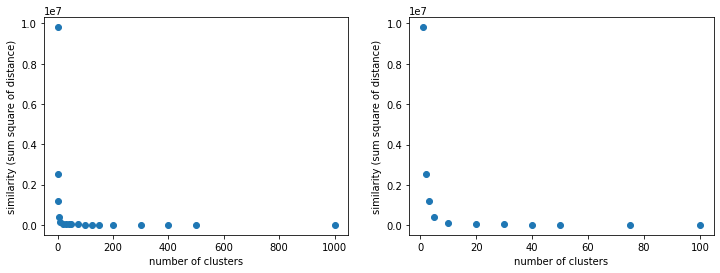

In [21]:
import matplotlib.pyplot as plt

ssds_df = pd.DataFrame(ssds)
plt.rcParams['figure.figsize'] = [12, 4]
plt.subplot(1, 2, 1)
plt.scatter(ssds_df["k"], ssds_df["ssd"])
plt.xlabel("number of clusters")
plt.ylabel("similarity (sum square of distance)")
plt.subplot(1, 2, 2)
ssds_df_short = ssds_df[ssds_df["k"] <= 100]
plt.scatter(ssds_df_short["k"], ssds_df_short["ssd"])
plt.xlabel("number of clusters")
plt.ylabel("similarity (sum square of distance)")
plt.show()

When we try clustering our songs using a range of choices for `k`, we see that we get a huge improvement when we go from `k = 1` to `k = 2`, but the jumps from `k = 2` => `k = 3`, `k = 3` => `k = 4`, and so on get sizably smaller each time. Ideally, we want to be any point past the "elbow bend" in our scree plot. Thus, we can see that based on our clustering, even though increasing `k` may improve our clusters, we see a substantial diminishing in improvement after `k = 20` or so, which means any choice of `k >= 20` that also maintains decently long playlists (roughly 20 songs) will work for our uses. 

If we pick `k = 100`, the vast majority of our clusters have at least 10 songs, with most having 25 or more. This will work for us.

In [25]:
saved_tracks_clustered2_df = cluster_tracks_plus_df(saved_tracks_plus_df, 100)
clusters, counts = np.unique(saved_tracks_clustered2_df["cluster"], return_counts = True)
counts_df = pd.DataFrame(list(zip(clusters, counts)), columns = ["cluster", "count"])
print("clusters with at least 10 songs: %d" % counts_df[counts_df["count"] >= 10].shape[0])
print("clusters with at least 20 songs: %d" % counts_df[counts_df["count"] >= 20].shape[0])
print("clusters with at least 25 songs: %d" % counts_df[counts_df["count"] >= 25].shape[0])

clusters with at least 10 songs: 88
clusters with at least 20 songs: 65
clusters with at least 25 songs: 53


### Analyze clusters qualitatively: how divided are specific artists

Another way we can assess the quality of our clusters is by simply looking at how artists, and albums are split up. Though there are obviously varience in an artist's discography and even within a single album, we would expect a particular artist or album to fall between a smaller number of clusters. If we see a certain artist appearing a few times in a handful of clusters, great! If we see every single one of an artist's songs in entirely different clusters, we may have to reassess.

To test this, we can count the number of distinct clusters that certain artists fall into, relative to the number of songs they have.

In [26]:
clusters_per_artist_df = saved_tracks_clustered2_df[["artists", "track_id", "cluster"]].groupby(["artists"]).agg(lambda x : len(np.unique(x)))
clusters_per_artist_df['songs_per_cluster'] = clusters_per_artist_df['track_id'] / clusters_per_artist_df['cluster']

print("number of artists: %d" % clusters_per_artist_df.shape[0])
print("average (median) number of songs per artist: %1.2f (%1.2f)" % 
      (clusters_per_artist_df['track_id'].mean(), clusters_per_artist_df['track_id'].median()))
print("average (median) number of songs from same artist per cluster: %1.2f (%1.2f)" % 
      (clusters_per_artist_df['songs_per_cluster'].mean(), clusters_per_artist_df['songs_per_cluster'].median()))

artists_of_interest = ["NEEDTOBREATHE", "Gregory Alan Isakov", "Wild Child", "Otis Redding", "Bad Bad Hats", "The Rubens"]
clusters_per_artist_df[clusters_per_artist_df.index.isin(artists_of_interest)]

number of artists: 851
average (median) number of songs per artist: 3.39 (1.00)
average (median) number of songs from same artist per cluster: 1.06 (1.00)


,track_id,cluster,songs_per_cluster
artists,,,
Bad Bad Hats,22,16,1.375000
Gregory Alan Isakov,31,17,1.823529
NEEDTOBREATHE,107,43,2.488372
Otis Redding,40,20,2.000000
The Rubens,26,17,1.529412
Wild Child,48,30,1.600000


In general, it seems like the artists in my library are relatively split, appearing around once per cluster. However, it seems like the majority of artists only have one song in my library, making it *difficult* to appear in more than one cluster. With more 851 distinct artists, it would be difficult to have a significant amount of artists appear in more than one playlist when there are only 100.

Of the six artists I singled out (some of my top listened to artists), some artists are more split than others. NEEDTOBREATHE has the most songs, but they appear in not that many different playlists relatively, averaging more than two songs per cluster. We also see similar dispersion for Otis Redding. On the other end, The Bad Bad Hats, who fewer songs, appeared in quite a few clusters, with relatively few duplicate apperances.

However, even though our `songs_per_cluster` metric is relatively low across most of our artists, I'm choosing to see this as another win for the experiment. The goal of this was never to create algorithimically generated playlists of one or two artists, since that is relatively trivial and not particularly helpful. We'd ideally want a mix of artists (of similar vibe) to appear in our playlists and it seems like that is happening for the most part.

### Analyze clusters visually: compare audio features

Finally, to assess the quality of our clustering both within a specific playlist and relative to other playlists, we can visualize the audio features of our songs. Since our clustering is based on similarity in these audio features, we would expect songs within a specific cluster to have similar audio features. In our initial attempt at clustering, we saw this happen overwhelming based on the length of the songs. Now that we have normalized our data, we still expect this to happen, just on more meaningful features.

To visualize this, we can use the old trusty box plot to compare the variability in different features within and between clusters.

In [70]:
# pick random sample of clusters to compare
rand_clusters = np.random.choice(saved_tracks_clustered2_df['cluster'].unique(), 5, False).tolist()
rand_clusters.sort()

print("random clusters: " + str(rand_clusters))

rand_clusters_df = saved_tracks_clustered2_df[saved_tracks_clustered2_df['cluster'].isin(rand_clusters)]
rand_clusters_df.head()

random clusters: [39, 40, 67, 72, 96]


,name,artists,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,cluster
9,No Glory in the West,Orville Peck,3M3A038dDopQcvGrrngcDE,1.053571,-1.628349,0.864470,-0.768850,-1.820823,-0.481583,1.482937,-0.358993,-0.283222,-0.988160,-0.391869,0.311153,-2.190140,3M3A038dDopQcvGrrngcDE,72
36,Elise,The Greeting Committee,6gjUxk2gNqaMtTYV0t3PPB,0.692373,-2.320098,-1.361372,-1.369855,0.549202,0.041601,1.608693,-0.395523,-0.109847,-0.901382,0.107202,0.328881,-2.190140,6gjUxk2gNqaMtTYV0t3PPB,72
90,Unlovely (feat. Darlingside),"The Ballroom Thieves, Darlingside",5AAZwjwMhoOQjhrj6xjOQp,-0.609303,-0.758670,-1.361372,0.087798,0.549202,-0.300729,1.028986,-0.264074,0.846924,-0.606337,0.470618,0.403006,0.262511,5AAZwjwMhoOQjhrj6xjOQp,39
106,Face In The Crowd - Acoustic,Palace,61aG11HMsq28RxM44yZ0Gy,-0.922795,-0.314957,-0.248451,0.239401,-1.820823,-0.239368,1.498273,-0.385824,-0.219009,-0.983821,-2.225648,-0.839042,0.262511,61aG11HMsq28RxM44yZ0Gy,40
110,You And Me,Penny & The Quarters,3ue9zcwNcoYvFqKVjG0C6r,0.160799,-1.779211,-1.361372,0.074557,0.549202,-0.379853,1.857139,-0.395490,-0.392384,-0.801587,-0.349289,-1.102969,0.262511,3ue9zcwNcoYvFqKVjG0C6r,39


In [71]:
def boxplot_cluster_features(df, feat, clusters):
    plt.rcParams['figure.figsize'] = [12, 5]
    plt.figure()
    fig, ax = plt.subplots()
    df[["cluster", feat]].boxplot(by = "cluster", ax = ax)

    for i in range(1, len(clusters) + 1):
        y = df[df["cluster"] == clusters[i - 1]][feat]
        x = np.random.normal(i, 0.04, size = len(y))
        plt.plot(x, y, 'r.', alpha=0.5)

<Figure size 864x360 with 0 Axes>

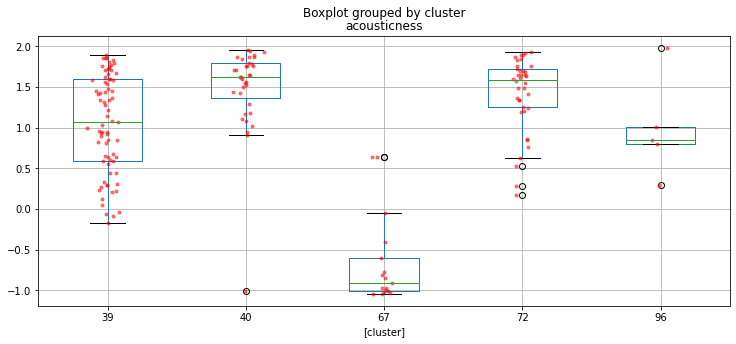

<Figure size 864x360 with 0 Axes>

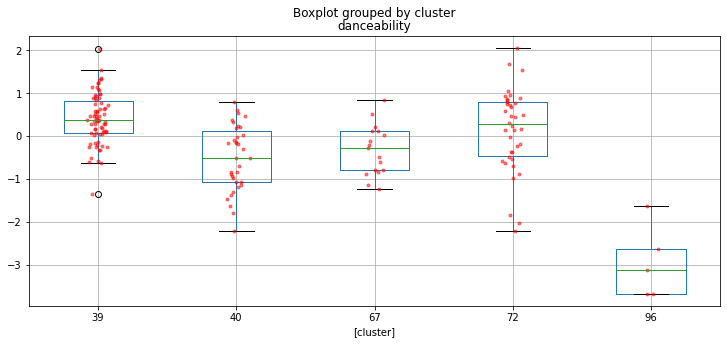

<Figure size 864x360 with 0 Axes>

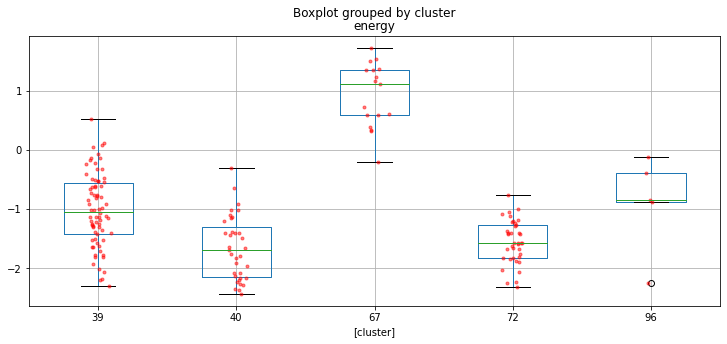

In [72]:
boxplot_cluster_features(rand_clusters_df, "acousticness", rand_clusters)
boxplot_cluster_features(rand_clusters_df, "danceability", rand_clusters)
boxplot_cluster_features(rand_clusters_df, "energy", rand_clusters)

These box plots show that, at least based on the features we looked at here, the clustering did seem to work effectively. Some of our clusters are similar on certain dimensions, which makes sense given they are sampled from my relatively consistent Spotify library (a lot of indie rock and pop). But there are some clusters (e.g., cluster 67) that stand out from the rest. If we look at cluster 67, we can see that almost all of the songs are live, which will lead to a significant difference in the energy and acousticness, which we see on the above box plots.

In [73]:
saved_tracks_clustered2_df[saved_tracks_clustered2_df['cluster'] == 67]

,name,artists,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,id,cluster
709,Live That Long,Lewis Del Mar,4WBXTnzVmz3Thn76w3rYUR,0.508367,-0.212902,-0.804911,-0.293234,0.549202,-0.387927,-0.599717,-0.395504,3.974089,-0.419764,1.067841,0.797089,0.262511,4WBXTnzVmz3Thn76w3rYUR,67
717,State I'm In - Live from the Woods,NEEDTOBREATHE,1Wwqql1imGvxH0HHjYpgMZ,-0.609303,1.717252,-0.804911,1.223871,0.549202,0.388776,-1.024530,-0.289675,4.988652,-0.380714,0.129611,0.453215,0.262511,1Wwqql1imGvxH0HHjYpgMZ,67
729,The Outsiders - Live from the Woods,NEEDTOBREATHE,4yqQrNma9tDnxlMU5zOIsU,-0.881905,1.490958,-0.804911,0.832299,0.549202,-0.253901,-0.775470,-0.212381,5.117078,-0.402409,-0.450613,1.812250,0.262511,4yqQrNma9tDnxlMU5zOIsU,67
731,"Feet, Don't Fail Me Now - Live",NEEDTOBREATHE,1IEndZMJLwBWYaksdzxte7,-0.214029,1.530892,0.586240,0.861214,0.549202,-0.052055,-0.847243,-0.395436,4.930860,0.152970,0.062384,0.110149,0.262511,1IEndZMJLwBWYaksdzxte7,67
1117,Circadian Rhythms (Dusk),Stop Light Observations,3DeqF1OQZfYWXGkEsxRhM8,-1.134062,0.585782,0.586240,0.418027,0.549202,-0.266819,-0.053749,-0.391471,3.274169,-1.009855,0.035100,0.518758,0.262511,3DeqF1OQZfYWXGkEsxRhM8,67
1436,Feel The Tide,Mumford & Sons,1QqF3P41w6s9K3zl2VizAz,-1.229473,0.337302,1.142700,-1.171772,0.549202,0.293505,-0.973000,-0.395502,4.879490,0.018465,0.560487,-0.184141,0.262511,1QqF3P41w6s9K3zl2VizAz,67
1511,Psycho,Muse,383QXk8nb2YrARMUwDdjQS,0.113093,1.348969,-0.804911,1.259542,0.549202,-0.383082,-1.037903,-0.193673,4.404315,0.313510,0.166046,1.273438,0.262511,383QXk8nb2YrARMUwDdjQS,67
1613,"Shout, Pts. 1 & 2",The Isley Brothers,5TUa3AsgSh3kJIuXn42wig,-0.486632,1.118238,1.420931,0.115092,0.549202,0.169168,0.642514,-0.395523,4.930860,0.487066,0.577987,0.520679,0.262511,5TUa3AsgSh3kJIuXn42wig,67
1615,Psycho,Muse,3WLfwlGFy5f2A4O1daqeq8,0.113093,1.348969,-0.804911,1.259542,0.549202,-0.383082,-1.037903,-0.193673,4.404315,0.313510,0.166046,1.273438,0.262511,3WLfwlGFy5f2A4O1daqeq8,67
1844,Zombies,Radiation City,7brt80lkHwoQV3apdWj2ET,0.835489,0.386111,1.142700,0.214539,0.549202,-0.326566,-0.409549,-0.380999,3.222799,-0.719148,-0.001469,-0.163411,0.262511,7brt80lkHwoQV3apdWj2ET,67


Overall, another score for k-means music!

---

## Generate and save some playlists

With all of this, I vote this experiment was a moderate -- maybe even overwhelming :) -- success, at least based on the few tests above. However, at the end of the day, the way to truly test the success of these playlists is going to be by listening to them. There is a huge amount of data wrapped up in all of the music we listen to, but at the end of the day, it sometimes just comes down to the \~vibe\~ you get from a playlist, which is hard to quantify.

I'm going to generate some of my own playlists and give them a listen. Feel free to check out my playlists ([link1](https://open.spotify.com/playlist/1AGTPGBsTzItxhFGcuAvO2?si=ENhxHvXeQgKWZ7TeIiQ3Wg), [link2](https://open.spotify.com/playlist/3bNw9SVvuAKM332uNulUOm?si=gkxfpodGThO9SFTlb8QogA), [link3](https://open.spotify.com/playlist/71nWnNiqi8uGi65TAtQBxD?si=3cvp5vi1TKGMC8-lWgLeqA)) and I also encourage you to generate some from your own library! I've saved all of the relevant code (without any of the validation code) [here](https://github.com/ben-tanen/kmeans-music), so feel free to play around for yourself. You'll have to set up your own Spotify API application to get a usable key, but you can find instructions on doing so [here](https://developer.spotify.com/documentation/web-api/).

Feel free to reach out with any questions, comments, or criticisms of the above - always looking to improve on my methods and music.

In [78]:
def save_cluster_tracks_to_playlist(playlist_name, track_ids):
    # get all of the users playlists
    all_playlists = get_all_user_playlists()
    
    # check if playlist already exists
    if (playlist_name not in [playlist['name'] for playlist in all_playlists]):
        playlist = sp.user_playlist_create(user = user_id, name = playlist_name, public = True)
    else:
        playlist_id = [playlist['id'] for playlist in all_playlists if playlist['name'] == playlist_name][0]
        playlist = sp.user_playlist(user = user_id, playlist_id = playlist_id)

    # remove any existing tracks in playlist
    while (playlist['tracks']['total'] > 0):
        sp.user_playlist_remove_all_occurrences_of_tracks(user_id, playlist['id'], \
                                                          tracks = [track['track']['id'] for track in \
                                                                    playlist['tracks']['items']])
        playlist = sp.user_playlist(user = user_id, playlist_id = playlist_id)

    # add tracks from cluster
    sp.user_playlist_add_tracks(user_id, playlist_id = playlist['id'], tracks = track_ids)

In [81]:
rand_clusters2 = np.random.choice(saved_tracks_clustered2_df['cluster'].unique(), 3, False).tolist()

for i in range(1, len(rand_clusters2) + 1):
    cluster = saved_tracks_clustered2_df[saved_tracks_clustered2_df['cluster'] == rand_clusters2[i - 1]]
    print(cluster[["name", "artists", "cluster"]].head())
    save_cluster_tracks_to_playlist("k-means, cluster %d" % i, list(cluster['id']))

                                                  name  \
233  Truth (feat. Alicia Keys & The Last Artful, Do...   
305                                       Good As Hell   
306                                           Water Me   
552                                      Favorite Song   
619                            Can We Hang On ? - Live   

                                              artists  cluster  
233  Mark Ronson, Alicia Keys, The Last Artful, Dodgr        5  
305                                             Lizzo        5  
306                                             Lizzo        5  
552                                           Sinkane        5  
619                                     Cold War Kids        5  
                 name              artists  cluster
155  Transatlanticism  Death Cab for Cutie       48
201      Turn to Hate         Orville Peck       48
687        Empiricist              Typhoon       48
691            Window         GoGo Penguin       48
9